In [1]:
import os
import numpy as np
import xarray as xr
import pandas as pd
from dask.array.core import normalize_chunks
from pathlib import Path
from sgkit_bgen import read_bgen
from sgkit_bgen.bgen_reader import unpack_variables, rechunk_to_zarr, rechunk_from_zarr
from bokeh.io import output_notebook, export_png
from dask.diagnostics import ResourceProfiler, ProgressBar, Profiler, visualize
%load_ext autoreload
%autoreload 2
output_notebook()

Loading BokehJS ...

In [2]:
import sys
sys.path.insert(0,'../scripts')
from convert_genetic_data import BGENPaths, Contig, load_bgen, rechunk_bgen, save_dataset

In [3]:
paths = BGENPaths(
    bgen_path='/home/eczech/data/rs-ukb-local/bgen/ukb_imp_chrXY_v3.bgen',
    variants_path='/home/eczech/data/rs-ukb-local/bgen/ukb_mfi_chrXY_v3.txt',
    samples_path='/home/eczech/data/rs-ukb-local/bgen/ukb59384_imp_chrXY_v3_s486331.sample',
)

In [4]:
# [t[0] for t in normalize_chunks('512MiB', shape=(90_000_000, 486443, 2), dtype='uint8')]

In [5]:
target_chunks = (10432, 11313)
target_chunks

(10432, 11313)

In [6]:
target_chunks[0] / 32

326.0

In [20]:
paths = BGENPaths(
    bgen_path='/home/eczech/data/rs-ukb-local/bgen/ukb_imp_chrXY_v3.bgen',
    variants_path='/home/eczech/data/rs-ukb-local/bgen/ukb_mfi_chrXY_v3.txt',
    samples_path='/home/eczech/data/rs-ukb-local/bgen/ukb59384_imp_chrXY_v3_s486331.sample',
)
contig = Contig(index=25, name='XY')
ds = load_bgen(paths, contig, region=(0, 4590), chunks=(326, -1))
#ds = load_bgen(paths, contig, region=(0, 2500), chunks=(250, -1))
ds

<xarray.Dataset>
Dimensions:                         (genotypes: 3, samples: 486443, variants: 4590)
Dimensions without coordinates: genotypes, samples, variants
Data variables:
    variant_id                      (variants) |S15 b'X:60014_T_C' ... b'X:38...
    variant_rsid                    (variants) |S15 b'rs370048753' ... b'rs73...
    variant_position                (variants) int32 60014 60014 ... 384198
    variant_allele1_ref             (variants) |S3 b'T' b'T' b'C' ... b'C' b'A'
    variant_allele2_alt             (variants) |S8 b'C' b'G' b'T' ... b'T' b'G'
    variant_maf                     (variants) float64 0.0003958 ... 0.07451
    variant_minor_allele            (variants) |S3 b'C' b'G' b'T' ... b'T' b'G'
    variant_info                    (variants) float64 0.7276 0.6867 ... 0.9599
    sample_id                       (samples) int32 4476413 3205773 ... 4315851
    sample_sex                      (samples) uint8 1 2 2 2 2 1 ... 1 2 2 1 2 1
    variant_contig                  (variants) int16 25 25 25 25 ... 25 25 25 25
    variant_contig_name             (variants) |S4 b'PAR1' b'XY' ... b'XY' b'XY'
    call_genotype_probability       (variants, samples, genotypes) float16 dask.array<chunksize=(326, 486443, 3), meta=np.ndarray>
    call_genotype_probability_mask  (variants, samples, genotypes) bool dask.array<chunksize=(326, 486443, 3), meta=np.ndarray>
Attributes:
    contigs:       ['PAR1', 'XY']
    contig_name:   XY
    contig_index:  25

In [8]:
%%time
with ResourceProfiler() as rprof, Profiler() as prof:
    # Uses 6GB peak on 4 workers
    dsr = rechunk_bgen(ds, '/tmp/ukb_imp_chrXY_v3.zarr', contig, progress_update_seconds=1, chunks=target_chunks)

2020-08-26 19:52:13,570 | convert_genetic_data | INFO | Rechunking BGEN dataset for contig Contig(name='XY', index=25) to /tmp/ukb_imp_chrXY_v3.zarr (chunks = (10432, 11313))
[########################################] | 100% Completed |  2min 59.4s
CPU times: user 11min 24s, sys: 16.6 s, total: 11min 40s
Wall time: 3min


In [9]:
visualize([prof, rprof])

Column(id='1126', ...)

In [10]:
dsr

<xarray.Dataset>
Dimensions:                         (genotypes: 2, samples: 486443, variants: 4590)
Dimensions without coordinates: genotypes, samples, variants
Data variables:
    call_genotype_probability       (variants, samples, genotypes) uint8 dask.array<chunksize=(4590, 11313, 2), meta=np.ndarray>
    call_genotype_probability_mask  (variants, samples) bool dask.array<chunksize=(4590, 11313), meta=np.ndarray>
    sample_id                       (samples) int32 dask.array<chunksize=(60806,), meta=np.ndarray>
    sample_sex                      (samples) uint8 dask.array<chunksize=(243222,), meta=np.ndarray>
    variant_allele1_ref             (variants) |S3 dask.array<chunksize=(4590,), meta=np.ndarray>
    variant_allele2_alt             (variants) |S8 dask.array<chunksize=(4590,), meta=np.ndarray>
    variant_contig                  (variants) int16 dask.array<chunksize=(4590,), meta=np.ndarray>
    variant_contig_name             (variants) |S4 dask.array<chunksize=(4590,), meta=np.ndarray>
    variant_id                      (variants) |S15 dask.array<chunksize=(4590,), meta=np.ndarray>
    variant_info                    (variants) float64 dask.array<chunksize=(4590,), meta=np.ndarray>
    variant_maf                     (variants) float64 dask.array<chunksize=(4590,), meta=np.ndarray>
    variant_minor_allele            (variants) |S3 dask.array<chunksize=(4590,), meta=np.ndarray>
    variant_position                (variants) int32 dask.array<chunksize=(4590,), meta=np.ndarray>
    variant_rsid                    (variants) |S15 dask.array<chunksize=(4590,), meta=np.ndarray>
Attributes:
    contig_index:  25
    contig_name:   XY
    contigs:       ['PAR1', 'XY']

In [10]:
dsr = rechunk_from_zarr(
    '/tmp/ukb_imp_chrXY_v3.zarr', 
    chunk_length=target_chunks[0],
    chunk_width=target_chunks[1], 
    mask_and_scale=False
)
dsr

<xarray.Dataset>
Dimensions:                         (genotypes: 2, samples: 486443, variants: 4590)
Dimensions without coordinates: genotypes, samples, variants
Data variables:
    call_genotype_probability       (variants, samples, genotypes) uint8 dask.array<chunksize=(4590, 11313, 2), meta=np.ndarray>
    call_genotype_probability_mask  (variants, samples) bool dask.array<chunksize=(4590, 11313), meta=np.ndarray>
    sample_id                       (samples) int32 dask.array<chunksize=(60806,), meta=np.ndarray>
    sample_sex                      (samples) uint8 dask.array<chunksize=(243222,), meta=np.ndarray>
    variant_allele1_ref             (variants) |S3 dask.array<chunksize=(4590,), meta=np.ndarray>
    variant_allele2_alt             (variants) |S8 dask.array<chunksize=(4590,), meta=np.ndarray>
    variant_contig                  (variants) int16 dask.array<chunksize=(4590,), meta=np.ndarray>
    variant_contig_name             (variants) |S4 dask.array<chunksize=(4590,), meta=np.ndarray>
    variant_id                      (variants) |S15 dask.array<chunksize=(4590,), meta=np.ndarray>
    variant_info                    (variants) float64 dask.array<chunksize=(4590,), meta=np.ndarray>
    variant_maf                     (variants) float64 dask.array<chunksize=(4590,), meta=np.ndarray>
    variant_minor_allele            (variants) |S3 dask.array<chunksize=(4590,), meta=np.ndarray>
    variant_position                (variants) int32 dask.array<chunksize=(4590,), meta=np.ndarray>
    variant_rsid                    (variants) |S15 dask.array<chunksize=(4590,), meta=np.ndarray>
Attributes:
    contig_index:  25
    contig_name:   XY
    contigs:       ['PAR1', 'XY']

In [11]:
dsr.call_genotype_probability.data.chunksize

(4590, 11313, 2)

In [12]:
%%time
with ResourceProfiler() as rprof, Profiler() as prof:
    save_dataset('/tmp/ukb_imp_chrXY_v3.out.zarr', dsr, contig, remote=False, progress_update_seconds=1)
    #save_dataset('gs://rs-ukb/tmp/ukb_imp_chrXY_v3.out.zarr', dsr, contig, remote=True, progress_update_seconds=1)

[########################################] | 100% Completed |  1min 35.2s
CPU times: user 6min 7s, sys: 5.71 s, total: 6min 13s
Wall time: 1min 36s


In [13]:
visualize([prof, rprof])

Column(id='1126', ...)

In [16]:
!du -ch /home/eczech/data/rs-ukb-local/bgen/ukb_imp_chrXY_v3.bgen

4.6G	/home/eczech/data/rs-ukb-local/bgen/ukb_imp_chrXY_v3.bgen
4.6G	total


In [15]:
!du -ch /tmp/ukb_imp_chrXY_v3.out.zarr --max-depth=1

28K	/tmp/ukb_imp_chrXY_v3.out.zarr/variant_position
44K	/tmp/ukb_imp_chrXY_v3.out.zarr/variant_info
16K	/tmp/ukb_imp_chrXY_v3.out.zarr/variant_allele1_ref
16K	/tmp/ukb_imp_chrXY_v3.out.zarr/variant_contig_name
16K	/tmp/ukb_imp_chrXY_v3.out.zarr/variant_minor_allele
28K	/tmp/ukb_imp_chrXY_v3.out.zarr/variant_id
32K	/tmp/ukb_imp_chrXY_v3.out.zarr/variant_rsid
96K	/tmp/ukb_imp_chrXY_v3.out.zarr/sample_sex
1.6M	/tmp/ukb_imp_chrXY_v3.out.zarr/sample_id
48K	/tmp/ukb_imp_chrXY_v3.out.zarr/variant_maf
462M	/tmp/ukb_imp_chrXY_v3.out.zarr/call_genotype_probability
16K	/tmp/ukb_imp_chrXY_v3.out.zarr/variant_allele2_alt
356K	/tmp/ukb_imp_chrXY_v3.out.zarr/call_genotype_probability_mask
16K	/tmp/ukb_imp_chrXY_v3.out.zarr/variant_contig
465M	/tmp/ukb_imp_chrXY_v3.out.zarr
465M	total


### Validate

In [31]:
dsr = xr.open_zarr('/tmp/ukb_imp_chrXY_v3.out.zarr')
dsr = unpack_variables(dsr, dtype='float16')
dsr

<xarray.Dataset>
Dimensions:                         (genotypes: 3, samples: 486443, variants: 4590)
Dimensions without coordinates: genotypes, samples, variants
Data variables:
    call_genotype_probability_mask  (variants, samples) int8 dask.array<chunksize=(4590, 11313), meta=np.ndarray>
    sample_id                       (samples) int32 dask.array<chunksize=(60806,), meta=np.ndarray>
    sample_sex                      (samples) uint8 dask.array<chunksize=(243222,), meta=np.ndarray>
    variant_allele1_ref             (variants) |S3 dask.array<chunksize=(4590,), meta=np.ndarray>
    variant_allele2_alt             (variants) |S8 dask.array<chunksize=(4590,), meta=np.ndarray>
    variant_contig                  (variants) int16 dask.array<chunksize=(4590,), meta=np.ndarray>
    variant_contig_name             (variants) |S4 dask.array<chunksize=(4590,), meta=np.ndarray>
    variant_id                      (variants) |S15 dask.array<chunksize=(4590,), meta=np.ndarray>
    variant_info                    (variants) float64 dask.array<chunksize=(4590,), meta=np.ndarray>
    variant_maf                     (variants) float64 dask.array<chunksize=(4590,), meta=np.ndarray>
    variant_minor_allele            (variants) |S3 dask.array<chunksize=(4590,), meta=np.ndarray>
    variant_position                (variants) int32 dask.array<chunksize=(4590,), meta=np.ndarray>
    variant_rsid                    (variants) |S15 dask.array<chunksize=(4590,), meta=np.ndarray>
    call_genotype_probability       (variants, samples, genotypes) float16 dask.array<chunksize=(4590, 11313, 1), meta=np.ndarray>
    call_dosage                     (variants, samples) float16 dask.array<chunksize=(4590, 11313), meta=np.ndarray>
    call_dosage_mask                (variants, samples) int8 dask.array<chunksize=(4590, 11313), meta=np.ndarray>
Attributes:
    contig_index:  25
    contig_name:   XY
    contigs:       ['PAR1', 'XY']

In [32]:
x1 = ds.call_genotype_probability[:1000, :10000].values
x2 = dsr.call_genotype_probability[:1000, :10000].values

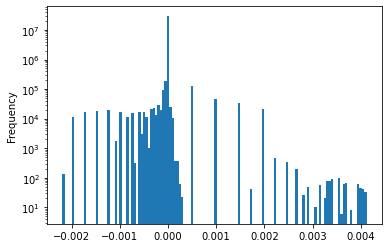

In [33]:
ax = pd.Series((x1 - x2).ravel()).plot(kind='hist', bins=128)
ax.set_yscale('log')